# **Pattern Recognition and Machine Learning**
## Unit Project
## **Movie Box-Office Prediction with Public Opinion Analysis**
> ### Author:

## Introduction

This project try to provide a machine learning based prediction of movie box-office using public opinion analysis in addition to movie metadata.

### Features selected:
+ _Trend_: Measurement of movie popularity on multiple platforms.
+ _Sentiment_: Measurement of public opinion (positive/negative).
+ _Public_: Measurement of movie rating from the public.
+ _Critic_: Measurement of movie rating from professiontal critics.
+ _Prospect_: Measurement of movie metadata (budget, etc.).

## Dataset

Data points are collected from _IMDB_, _Rotten Tomatoes_, _Box Office Mojo_ and _YouTube_. They are organized and stored as CSV file by the author. 

### Shape:
+ Entries: 60
+ Columns: 13

### Attributes:
+ `movie`: Movie name.
+ `box`: Box-office value in million USD from _Box Office Mojo_.
+ `budget`: Budget value in million USD from _Box Office Mojo_.
+ `pop_rating`: Count of user ratings for the movie on _IMDB_.
+ `pop_review`: Count of user reviews for the movie on _IMDB_.
+ `pop_trailer`: Count of views for the movie trailer (Most popular) on _YouTube_.
+ `critic_rt`: Tomatometer score (Critic rating) of the movie on _Rotten Tomatoes_
+ `critic_ms`: Metascore (Critic rating) of the movie on _IMDB_.
+ `public_rt`: Audience score of the movie on _Rotten Tomatoes_.
+ `public_imdb`: User Rating of the movie on _IMDB_.
+ `opinion_pos`: Count of positive opinion from the trailer on _YouTube_.
+ `opinion_neg`: Count of negative opinion from the trailer on _YouTube_.
+ `year`: Release year of the movie.


## Import Library

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import f_regression, chi2
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, mean_absolute_percentage_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import ElasticNetCV, LinearRegression, TweedieRegressor, ElasticNet
from sklearn.ensemble import RandomForestRegressor

## Load and Explore the Dataset

In [5]:
df = pd.read_csv("assets/main_dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie        60 non-null     object 
 1   box          60 non-null     int64  
 2   pop_rating   60 non-null     int64  
 3   pop_trailer  60 non-null     int64  
 4   pop_review   60 non-null     float64
 5   budget       60 non-null     float64
 6   critic_rt    60 non-null     int64  
 7   critic_ms    60 non-null     int64  
 8   public_rt    60 non-null     int64  
 9   public_imdb  60 non-null     float64
 10  opinion_pos  60 non-null     int64  
 11  opinion_neg  60 non-null     float64
 12  year         60 non-null     int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 6.2+ KB


In [6]:
df.tail(5)

,movie,box,pop_rating,pop_trailer,pop_review,budget,critic_rt,critic_ms,public_rt,public_imdb,opinion_pos,opinion_neg,year
55,Dark Phoenix,252,171,19819,2.2,200.0,22,43,64,5.7,244,15.0,2019
56,Glass,246,225,27603,2.0,20.0,36,43,67,6.6,259,7.8,2019
57,Charlies Angels,73,65,24106,1.2,48.0,52,52,78,4.9,289,58.0,2019
58,Fast & Furious Presents Hobbs & Shaw,759,195,120706,1.3,200.0,67,60,88,6.4,449,20.0,2019
59,Alita Battle Angel,404,248,19488,2.8,170.0,61,53,92,7.3,160,6.6,2019


##  Data Wrangling

array([[<AxesSubplot:title={'center':'ratio'}>]], dtype=object)

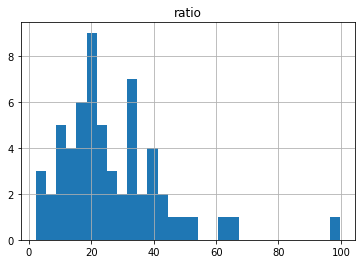

In [7]:
# Get sentiment score as a ratio of positive/ngative opinion.
df["ratio"] = (df["opinion_pos"] / df["opinion_neg"])

df.hist(column="ratio", bins=30)

In [8]:
# Extract corresponding columns to preprocess.
cols = ['pop_rating', 'pop_trailer', 'pop_review', 'budget',
        'critic_rt', 'critic_ms', 'public_rt', 'public_imdb',
        'ratio']
X = df[cols]

# Apply min-max scaling for all values.
X = pd.DataFrame(MinMaxScaler().fit_transform(X))
X.columns = cols

# Calulate for final values of the features from corresponding columns.
X['trend'] = (X['pop_trailer'] + X['pop_rating'] + X['pop_review'])/3
X['sentiment'] = X['ratio'] * X['pop_trailer']
X['public'] = (X['public_imdb'] + X['public_rt'])/2 * X['trend']
X['critic'] = (X['critic_ms'] + X['critic_rt'])/2
X['prospect'] = X['budget']

# Select final features and target.
features = [
    'trend', 'sentiment', 'public', 'critic', 'prospect'
]

X = X[features]
y = df['box']

# Apply f-test for the features.
f_regression(X, y)

(array([76.88283286, 65.43177827, 44.61918649,  1.2423821 , 81.61660608]),
 array([3.20465782e-12, 4.34510323e-11, 1.00932043e-08, 2.69609907e-01,
        1.16456916e-12]))

## Data Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=3)

print(f'Train set: {X_train.shape}')
print(f'Test set: {X_test.shape}')

Train set: (48, 5)
Test set: (12, 5)


## Fit Estimators (Models)

### Grid Search with Cross-Validation

In [14]:
# Select models to find optiaml hyper-parameters.

'''1 Penelized Linear Model.

For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
'''
# estimator = ElasticNet(max_iter=10000)
# param = [{
#     'alpha': np.linspace(0, 1, 20),
#     'l1_ratio': np.linspace(0, 1, 20),
# }]

'''2 Support Vector Machine.

Linear kernel: 'linear'
Radial basis function kernel: 'rbf'
'''
# estimator = SVR(kernel='linear')
estimator = SVR(kernel='rbf')
param = [{
    'gamma': np.logspace(-2, 10, 20),
    'C': np.logspace(-9, 3, 20)
}]

'''3 KNN.'''
# estimator = KNeighborsRegressor()
# param = [{
#     'n_neighbors': [1, 2, 3, 4, 5, 6, 7]
# }]

'''4 GLM.

| Power  | Distribution     |
| ------ | ---------------- |
| 0      | Normal           |
| 2      | Poisson          |
| (1, 2) | Compound         |
| 2      | Gamma            |
| 3      | Inverse Gaussian | 
'''
# estimator = TweedieRegressor(max_iter=10000)
# param = [{
#     'power': [0, 1, 1.1, 1.3, 1.5, 1.7, 1.9, 2, 2.5, 3], 
# }]

gscv = GridSearchCV(
    estimator = estimator,
    param_grid = param,
    cv = 3,
    scoring = 'neg_root_mean_squared_error'
)

gscv.fit(X_train.values, y_train.values);

gscv.best_params_

{'C': 1000.0, 'gamma': 0.18329807108324356}

### Randomized Search with Cross-Validation

In [ ]:
# Ensamble method for decision trees model.
param = {
    'n_estimators': randint(1, 10),
    'max_depth': randint(5, 10)
}

search = RandomizedSearchCV(
    estimator = RandomForestRegressor(random_state=0),
    n_iter = 10,
    param_distributions = param,
    random_state = 0
)

search.fit(X_train.values, y_train.values);

In [ ]:
# Alternative work flow using pipe.

# pipe = make_pipeline(
#     # StandardScaler(),
#     # MinMaxScaler(),
#     gscv
#     search
# )

# pipe.fit(X_train.values, y_train.values)

## Predict and Evaluation

### Calculate the metrics

In [15]:
y_pred = gscv.predict(X_test.values)
# y_pred = search.predict(X_test.values)
# y_pred = pipe.predict(X_test.values)

print(f'RMSE: {mean_squared_error(y_test, y_pred)**(1/2)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'EVS: {explained_variance_score(y_test, y_pred)}')

RMSE: 107.65647421349308
MAE: 75.33975709115721
MAPE: 0.17474654847950985
EVS: 0.9644974654268472


### Display the results

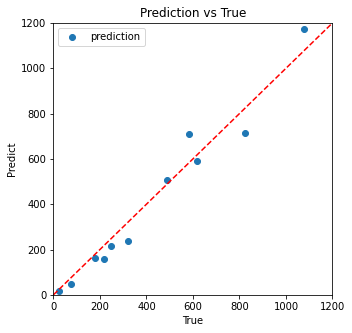

In [24]:
# Scatter of predictions vs observations.
ig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred)
plt.legend(['prediction'])
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', c='red')
plt.title('Prediction vs True')
plt.xlabel('True')
plt.ylabel('Predict')
plt.xlim([0, 1200])
plt.ylim([0, 1200])
plt.show()

In [18]:
# Compare values.
pd.DataFrame(
    {
        "True": y_test,
        "Predict": y_pred
    }
)

,True,Predict
47,583,711.902944
18,321,237.643363
56,246,213.659418
13,75,45.891008
37,490,507.732221
23,217,157.326167
6,180,161.558253
28,1078,1172.889576
12,2048,1752.127155
33,619,591.293825
